<a href="https://colab.research.google.com/github/takuya-tokumoto/GDL_code/blob/master/colab_pytorch/3%E7%AB%A0_%E5%A4%89%E5%88%86%E3%82%AA%E3%83%BC%E3%83%88%E3%82%A8%E3%83%B3%E3%82%B3%E3%83%BC%E3%83%80_%E3%82%AA%E3%83%BC%E3%83%88%E3%82%A8%E3%83%B3%E3%82%B3%E3%83%BC%E3%83%80(VAE)ver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

【README】  
- 変分オートエンコーダを利用して、手書き文字データから新たな画像を生成
- Pytorchによる実装
- 参考・引用
    - https://atmarkit.itmedia.co.jp/ait/articles/2007/10/news024_2.html
    - https://ichi.pro/pytorch-de-tatamikomi-vae-o-kochikusuru-176975412232049
    -https://qiita.com/kenmatsu4/items/b029d697e9995d93aa24
    -https://tips-memo.com/vae-pytorch
    -https://deepblue-ts.co.jp/image-generation/pytorch_vae/

# 準備

In [22]:
!pip install torchinfo
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torchinfo import summary
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [24]:
def describe_model(model:torch.nn.Module, input_size:tuple, input_data=None):
    if input_data is None:
        summary_str = summary(model,
            input_size=input_size,
            col_names=['input_size', 'output_size', 'num_params', 'kernel_size', 'mult_adds'],
            col_width=18,
            row_settings=['var_names'],
            verbose=1)
    else:
        summary_str = summary(model,
            input_data=input_data,
            col_names=['input_size', 'output_size', 'num_params', 'kernel_size', 'mult_adds'],
            col_width=18,
            row_settings=['var_names'],
            verbose=1)

# データ読み込み

In [30]:
transform = transforms.Compose([transforms.ToTensor(),
                                # transforms.Normalize((0.5,), (0.5,)),  # 正規化を行うとlossが計算できない
                                transforms.Lambda(lambda x: x.view(-1))]) # 画像の一次元配列化

trainset = MNIST('./data', train = True, transform = transform, download = True)
testset = MNIST('./data', train = False, transform = transform, download = True)

batch_size = 50
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
testloader = DataLoader(testset, batch_size = batch_size, shuffle = True)

# 学習

In [25]:
class VAE(nn.Module):
    def __init__(self, z_dim):
      super(VAE, self).__init__()
      self.dense_enc1 = nn.Linear(28*28, 200)
      self.dense_enc2 = nn.Linear(200, 200)
      self.dense_encmean = nn.Linear(200, z_dim)
      self.dense_encvar = nn.Linear(200, z_dim)
      self.dense_dec1 = nn.Linear(z_dim, 200)
      self.dense_dec2 = nn.Linear(200, 200)
      self.dense_dec3 = nn.Linear(200, 28*28)
    
    def _encoder(self, x):
      x = F.relu(self.dense_enc1(x))
      x = F.relu(self.dense_enc2(x))
      mean = self.dense_encmean(x)
      var = F.softplus(self.dense_encvar(x))
      return mean, var
    
    def _sample_z(self, mean, var):
      epsilon = torch.randn(mean.shape)
      return mean + torch.sqrt(var) * epsilon
 
    def _decoder(self, z):
      x = F.relu(self.dense_dec1(z))
      x = F.relu(self.dense_dec2(x))
      x = F.sigmoid(self.dense_dec3(x))
      return x

    def forward(self, x):
      mean, var = self._encoder(x)
      z = self._sample_z(mean, var)
      x = self._decoder(z)
      return x, z
    
    def loss(self, x):
      mean, var = self._encoder(x)
      KL = -0.5 * torch.mean(torch.sum(1 + torch.log(var) - mean**2 - var))
      z = self._sample_z(mean, var)
      y = self._decoder(z)
      reconstruction = torch.mean(torch.sum(x * torch.log(y) + (1 - x) * torch.log(1 - y)))
      lower_bound = [-KL, reconstruction]                                      
      return -sum(lower_bound)

In [31]:
from torch import optim

model = VAE(10)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

VAE(
  (dense_enc1): Linear(in_features=784, out_features=200, bias=True)
  (dense_enc2): Linear(in_features=200, out_features=200, bias=True)
  (dense_encmean): Linear(in_features=200, out_features=10, bias=True)
  (dense_encvar): Linear(in_features=200, out_features=10, bias=True)
  (dense_dec1): Linear(in_features=10, out_features=200, bias=True)
  (dense_dec2): Linear(in_features=200, out_features=200, bias=True)
  (dense_dec3): Linear(in_features=200, out_features=784, bias=True)
)

In [32]:
for i in range(3):
  losses = []
  for x, t in trainloader:
      x = x
      model.zero_grad()
      y = model(x)
      loss = model.loss(x)
      loss.backward()
      optimizer.step()
      losses.append(loss.cpu().detach().numpy())
  print("EPOCH: {} loss: {}".format(i, np.average(losses)))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


EPOCH: 0 loss: 8066.8310546875
EPOCH: 1 loss: 6110.7197265625
EPOCH: 2 loss: 5768.47607421875


# 生成

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


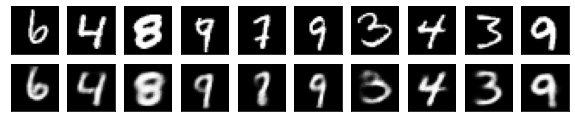

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10, 3))

model.eval()
zs = []
for x, t in testloader:
    # original
    for i, im in enumerate(x.view(-1, 28, 28).detach().numpy()[:10]):
      ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
      ax.imshow(im, 'gray')
    x = x
    # generate from x
    y, z = model(x)
    zs.append(z)
    y = y.view(-1, 28, 28)
    for i, im in enumerate(y.cpu().detach().numpy()[:10]):
      ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
      ax.imshow(im, 'gray')
    # # generate from z
    # z1to0 = torch.cat([z[1] * (i * 0.1) + z[0] * ((9 - i) * 0.1) for i in range(10)])
    # y2 = model._decoder(z1to0).view(-1, 28, 28)
    # for i, im in enumerate(y2.cpu().detach().numpy()):
    #   ax = fig.add_subplot(3, 10, i+21, xticks=[], yticks=[])
    #   ax.imshow(im, 'gray')
    break

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


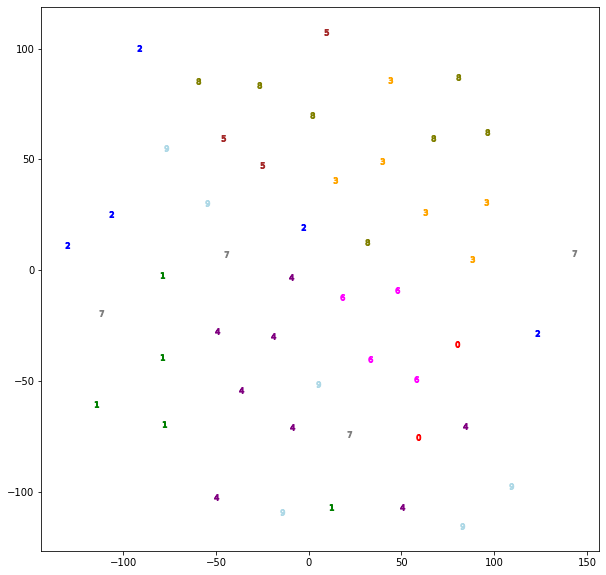

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from random import random

colors = ["red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue"]
def visualize_zs(zs, labels):
  plt.figure(figsize=(10,10))
  points = TSNE(n_components=2, random_state=0).fit_transform(zs)
  for p, l in zip(points, labels):
    plt.scatter(p[0], p[1], marker="${}$".format(l), c=colors[l])
  plt.show()

model.eval()
zs = []
for x, t in testloader:
    x = x
    t = t
    # generate from x
    y, z = model(x)
    z = z.cpu()
    t = t.cpu()
    visualize_zs(z.detach().numpy(), t.cpu().detach().numpy())
    break